In [1]:
# Processing long term monthly NARR variables that have been regridded (using CDO)
# to 1x1 degree spatial resolution over North America
# Then training NN model on GIM inverse fluxes using NARR features
# then estimating long term NA fluxes using longterm NARR

In [39]:
import numpy as np
import os.path
from netCDF4 import Dataset
import netCDF4
from sklearn import preprocessing
import matplotlib.pyplot as plt
from cartopy import config
import cartopy.crs as ccrs
import os
import scipy.stats
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras import backend as K 
from keras import regularizers
import shap
import itertools


In [2]:
# Directory for flux data
data_dir = "/Users/yshiga/Documents/Research/Carbon_Machine/Monthly/"


# Directory for NARR longterm data
data_dir_narr = "/Users/yshiga/Documents/Data/NARR/Monthly/degree/"

# Directory for saved NN models
model_dir = "/Users/yshiga/Documents/Research/Carbon_Machine/NN_models/"

In [3]:
# data-to-grid mapping function - converts lat,lon,data over North America to gridded map for plotting
def data2grid(lats,lons,data):
    # create grid of lat lon (expand lat by 5 degrees)
    xi = np.arange(lons.min(), lons.max()+1,1)
    yi = np.arange(lats.min(), lats.max()+5,1)
    xi, yi = np.meshgrid(xi, yi)
    zi = np.zeros(yi.shape) # place holder for flux variable

    # loop over values, find index of lat & lon, enter flux variable
    for i in range(len(data)):
        min_temp_lat=abs(lats[i]-yi[:,0])
        min_temp_lon=abs(lons[i]-xi[0,:])
        lat_ind = (min_temp_lat == min(min_temp_lat))
        lon_ind = (min_temp_lon == min(min_temp_lon))
        zi[lat_ind,lon_ind]=data[i]
    return xi, yi, zi

In [4]:
# data_finder_NA function - extract data over North America 
# using lat_NA and lon_NA locations from a data_cube (time,lat,lon)
# Looop over each location, find and extract nearest point in data_cube
# create new data_cube_new (time, values) in the order of the lat_NA lon_NA locations

def data_finder_NA(lat_NA,lon_NA,data_cube,data_cube_lat,data_cube_lon):
    # create grid of lat lon (expand lat by 5 degrees)
    xi = data_cube_lon
    yi = data_cube_lat
    xi, yi = np.meshgrid(xi, yi)
    zi = np.zeros((data_cube.shape[0],lat_NA.shape[0])) # place holder for flux variable

    # loop over values, find index of lat & lon, enter flux variable
    for i in range(len(lat_NA)):
        min_temp_lat=abs(lat_NA[i]-yi[:,0])
        min_temp_lon=abs(lon_NA[i]-xi[0,:])
        lat_ind = (min_temp_lat == min(min_temp_lat))
        lon_ind = (min_temp_lon == min(min_temp_lon))
        zi[:,i]=np.squeeze(data_cube[:,lat_ind,lon_ind])
    return zi

In [5]:
def transform_features(feature_train,feature_validation):
    #scaler_x_train = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaler_x_train = preprocessing.StandardScaler()
    scaler_x_train.fit(feature_train)
    X_train = scaler_x_train.fit_transform(feature_train) # transform training data
    
    #scaler_x_test = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaler_x_test = preprocessing.StandardScaler()
    scaler_x_test.fit(feature_validation)
    X_test = scaler_x_test.fit_transform(feature_validation) # transform test data
    return X_train,X_test

In [6]:
def model_scatter_correlation(model,X_test,y_test):
    # Scatter plot of estimates and test values
    y_est = model.predict(X_test,batch_size=len(X_test))
    a = plt.axes
    xy_line = (-7, 7)
    # plt.scatter(scaler_y_test.inverse_transform(y_test),y_est)
    plt.scatter(y_test,y_est)
    plt.plot(xy_line,xy_line ,'--r')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.ylim(-7, 7)   # set the xlim to left, right
    plt.xlim(-7, 7)  
    plt.grid(True)
   
    # Basic stats on test predictions
    var1=y_test
    var2=y_est
    # calculate correlation coefficient
    C = np.corrcoef(var1,var2,rowvar=False)
    C = C[0,1]
    # Calculate sum
    s1 = sum(var1)
    s2 = sum(var2)
    str_sum = "Sum (truth) = " + f'{s1[0]:.0f}' + "\n" + "Sum (est) = " + f'{s2[0]:.0f}'
    # Calculate mean
    m1=np.mean(var1)
    m2=np.mean(var2)
    str_mean = "Mean (truth) = " + f'{m1:.3f}' + "\n" + "Mean (est) = " + f'{m2:.3f}'
    plt.text(-6,6, 'Corrcoef = ' + f'{C:.2f}' + "\n" + str_sum + "\n" + str_mean ,verticalalignment='top')

In [7]:
def model_spatial_plots(model,feature,target,lats,lons):
    
    # plotting example for test data (not included in training aka 9th year = 2015)
    y_est = model.predict(feature,batch_size=len(feature)) # model estimates for test data (outside of training)
    # plot flux data
    flux_est = np.reshape(np.ravel(y_est, order='F'),(2613*12,-1),order='F') # reshape and average over months
    flux_est = flux_est.mean(axis=1) # average over years
    flux_est = flux_est.reshape(12,2613).mean(axis=0)# average over years

    flux_test = target
    flux_test = np.reshape(np.ravel(flux_test, order='F'),(2613*12,-1),order='F') # reshape and average over months
    flux_test = flux_test.mean(axis=1) # average over years
    flux_test = flux_test.reshape(12,2613).mean(axis=0)# average over years

    xi, yi, zi_flux = data2grid(lats,lons,flux_est) # regrid for plotting "model"
    xt, yt, zt_flux = data2grid(lats,lons,flux_test) # regrid for plotting "truth"
    xd, yd, zd_flux = data2grid(lats,lons,flux_est-flux_test) # regrid for plotting "model-truth"

    # set equal color limits for comparison 
    levels = np.linspace(-1.6, 1.6, 9)

    # plot TRUTH
    # projection axis
    ax = plt.axes(projection=ccrs.PlateCarree())

    # plot contour of variable using gridded  lat, lon, and variable
    plt.contourf(xi, yi, zt_flux, 60,levels=levels,
                 transform=ccrs.PlateCarree(),extend='both')
    # add coasts
    ax.coastlines()

    # title
    plt.title("Truth")

    # color bar
    plt.colorbar()

    plt.show()

    # plot estimates
    # projection axis  
    ax = plt.axes(projection=ccrs.PlateCarree())

    levels = np.linspace(-1.6, 1.6, 9)

    # plot contour of variable using gridded  lat, lon, and variable
    plt.contourf(xi, yi, zi_flux, 60,levels=levels,
                 transform=ccrs.PlateCarree(),extend='both')

    # add coasts
    ax.coastlines()

    # title
    plt.title("Model estimates")
    plt.colorbar()
    plt.show()

    # plot estimates
    # projection axis  
    ax = plt.axes(projection=ccrs.PlateCarree())
    levels = np.linspace(-1.6/2, 1.6/2, 9)

    # plot contour of variable using gridded  lat, lon, and variable
    plt.contourf(xd, yd, zd_flux, 60,levels=levels,
                 transform=ccrs.PlateCarree(),cmap= 'BrBG_r',extend='both')

    # add coasts
    ax.coastlines()
    # title
    plt.title("Difference Model minus Truth")
    plt.colorbar()
    plt.show()

In [8]:
def model_seasonal_plots(model,feature,target):
    # plot monthly averages for test year
    flux_test = target
    y_est = model.predict(feature,batch_size=len(feature)) # model estimates for test data (outside of training)

    # reshape to average by month
    b = np.reshape(np.ravel(flux_test, order='F'), (2613,12,1,-1),order='F')
    a = np.reshape(np.ravel(y_est, order='F'), (2613,12,1,-1),order='F') 

    # average by year
    X_test_mon = np.mean(a,axis=0)
    X_tru_mon = np.mean(b,axis=0)

    # average by month
    X_test_mon = np.mean(X_test_mon,axis=1)
    X_tru_mon = np.mean(X_tru_mon,axis=1)

    # month variable
    mon_array = np.arange(1, 13, dtype=float)

    # plot monthly averages averaged over all North America
    plt.plot(mon_array,X_test_mon[:,0],'-o',label="Model Estimates")

    plt.plot(mon_array,X_tru_mon[:,0],'-ok',label="Truth")
    plt.grid(True)
    plt.legend(loc="lower left")
    plt.xlabel('Month')
    plt.ylabel('Flux')
    plt.title('North America average monthly')
    fig = plt.gcf()
    fig.set_size_inches(10.5, 6.5)
    plt.show()

In [9]:
def nn_model_train(model,target_train,feature_train,target_validation,feature_validation,epoch_number):
    # patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
    # Training
    history = model.fit(
    feature_train, target_train, 
    epochs=epoch_number,
    # suppress logging
    verbose=0,
    batch_size = 256,
    shuffle = True,
    # validate using last year of data
    validation_data=(feature_validation, target_validation),
    callbacks=[es])
    return history

In [10]:
def model_maker(model,X_full):
    if model=="linear":
        # Linear model  (see : https://www.tensorflow.org/tutorials/keras/regression)
        K.clear_session()
        model_out = Sequential()
        model_out.add(Dense(1,input_dim=X_full.shape[1], activation='linear'))
        optimizer = keras.optimizers.sgd()
        model_out.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
    else:
        # NN model
        K.clear_session() # clear keras
        
        model_out = Sequential() # Define NN model
        
        # will add three 100 node relu layers + 10 node relu + 5 node relu + output layer
        
        # All 100 node layers will have same batch normalization and dropout rate
        model_out.add(Dense(100,input_dim=X_full.shape[1], activation='relu'))
        model_out.add(BatchNormalization()) # add batch normalization layer
        model_out.add(Dropout(.25))        # dropout rate 50%

        model_out.add(Dense(100,input_dim=X_full.shape[1], activation='relu'))
        model_out.add(BatchNormalization())
        model_out.add(Dropout(.25)) # dropout rate 25%

        model_out.add(Dense(100,input_dim=X_full.shape[1], activation='relu'))
        model_out.add(BatchNormalization())
        model_out.add(Dropout(.25)) # dropout rate 25%

        model_out.add(Dense(50,input_dim=X_full.shape[1], activation='relu'))
        model_out.add(BatchNormalization())
        model_out.add(Dropout(.25)) # dropout rate 25%

        model_out.add(Dense(10,input_dim=X_full.shape[1], activation='relu'))
        model_out.add(BatchNormalization())

        model_out.add(Dense(5,input_dim=X_full.shape[1], activation='relu'))
        model_out.add(BatchNormalization())

        # add output layer
        model_out.add(Dense(1, activation='linear')) #linear

        # set learning rate
        optimizer = keras.optimizers.adam()

        # pick loss function
        model_out.compile(loss='mae', optimizer=optimizer, metrics=['mae'])
        
    return model_out

In [11]:
# create plotting function *** note ylim and values from history ****
def plot_loss_2(history,model):
  plt.plot(history.history['loss'],'--', label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  batch_str= str(history.params['batch_size'])
  lr_str = str(model.optimizer.get_config()['learning_rate'])
  plt.title(('Batch Size = ' +  batch_str + ', Learning rate = ' + lr_str[0:5] ))
  plt.ylim([0.15, .5])
  plt.xlabel('Epoch')
  plt.ylabel('MAE Error [flux]')
  plt.legend()
  plt.grid(True)

In [12]:
def create_hold_outs(validation_binary,target,features):
    target_train = target[validation_binary==1,:]
    feature_train = features[validation_binary==1,:]
    target_validation = target[validation_binary==0,:]
    feature_validation = features[validation_binary==0,:]
    return target_train,feature_train,target_validation,feature_validation

In [13]:
# Test for Air Temp at 2m
# Load in NARR data (for lat lon locations)

# filename for long term NARR data
filename_narr = data_dir_narr + "air.2m.mon.mean.1deg_con.nc"
nc_narr = Dataset(filename_narr, 'r')  # open narr file using netcdf reader
lon_var = np.array(nc_narr.variables["lon"]) # create numpy array note shape of lat vars is [space dimension ]
lat_var = np.array(nc_narr.variables["lat"]) # create numpy array note shape of lat vars is [space dimension ]
narr_var = np.array(nc_narr.variables["air"])

# filename for North America NARR data (for lat lon)
filename_narr_NA = data_dir + "predictors/processed/narr-2007-NA-monthly.nc"
nc_narr_NA = Dataset(filename_narr_NA, 'r')  # open data file using netcdf reader
lat_NA_var = np.array(nc_narr_NA.variables["lat"]) # create numpy array note shape of lat vars is [space dimension ]
lon_NA_var = np.array(nc_narr_NA.variables["lon"]) # create numpy array note shape of lat vars is [space dimension ]

var_NA = data_finder_NA(lat_NA_var,lon_NA_var,narr_var,lat_var,lon_var)


In [14]:
# Time variable
time_var = np.array(nc_narr.variables["time"])
time = nc_narr.variables['time'] # do not cast to numpy array yet 
time_convert = netCDF4.num2date(time[:], time.units, time.calendar)
time_convert[0]


cftime.DatetimeGregorian(1979, 1, 1, 0, 0, 0, 0)

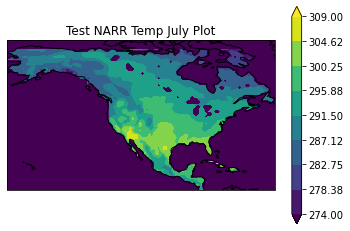

In [15]:
var_to_plot = var_NA[6,:]
xi, yi, zi_flux = data2grid(lat_NA_var,lon_NA_var,var_to_plot) # regrid for plotting

# projection axis    
ax = plt.axes(projection=ccrs.PlateCarree())

# plot contour of variable using gridded  lat, lon, and variable
lower_lim = np.round(np.mean(var_to_plot)-3*np.std(var_to_plot))
upper_lim = np.round(np.mean(var_to_plot)+3*np.std(var_to_plot))

levels = np.linspace(lower_lim, upper_lim, 9)

# plot contour of variable using gridded  lat, lon, and variable
plt.contourf(xi, yi, zi_flux, 60,levels=levels,
                 transform=ccrs.PlateCarree(),extend='both')
#add coasts
ax.coastlines()

# title
plt.title("Test NARR Temp July Plot")
plt.colorbar()

plt.show()

(0.0, 250.0)

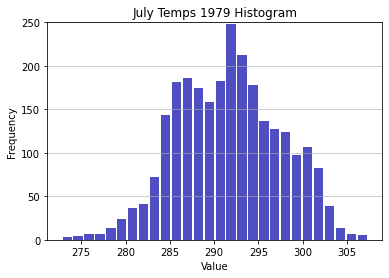

In [16]:
n, bins, patches = plt.hist(x=var_to_plot, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('July Temps 1979 Histogram')
#plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [17]:
all_names = []
all_file_names = []
keyword = '_con'
final = []
for fname in os.listdir(data_dir_narr):
    if keyword in fname:
        print(fname, "has the keyword")
        # filename for long term NARR data
        filename_narr = data_dir_narr + fname
        nc_narr = Dataset(filename_narr, 'r')  # open narr file using netcdf reader
        lon_var = np.array(nc_narr.variables["lon"]) # create numpy array note shape of lat vars is [space dimension ]
        lat_var = np.array(nc_narr.variables["lat"]) # create numpy array note shape of lat vars is [space dimension ]
        
        list_names=list(nc_narr.variables.keys())
        var_name = list_names[-2]
        all_names.append(var_name)
        all_file_names.append(fname)
        
        narr_var = np.array(nc_narr.variables[var_name])
        
        var_NA = data_finder_NA(lat_NA_var,lon_NA_var,narr_var,lat_var,lon_var)
        num_rows, num_cols = var_NA.shape # number of rows and columns
        final.append(np.reshape(var_NA, (num_rows*num_cols,1)))
        #final.append(var_NA.reshape((num_rows*num_cols, 1),order='F')) # reshape into one vector by stacking each column (month)
        

evap.mon.mean.1deg_con.nc has the keyword
soilm.mon.mean.1deg_con.nc has the keyword
cnwat.mon.mean.1deg_con.nc has the keyword
dswrf.mon.mean.1deg_con.nc has the keyword
apcp.mon.mean.1deg_con.nc has the keyword
air.sfc.mon.mean.1deg_con.nc has the keyword
prate.mon.mean.1deg_con.nc has the keyword
snowc.mon.mean.1deg_con.nc has the keyword
rhum.2m.mon.mean.1deg_con.nc has the keyword
shum.2m.mon.mean.1deg_con.nc has the keyword
ccond.mon.mean.1deg_con.nc has the keyword
air.2m.mon.mean.1deg_con.nc has the keyword
snod.mon.mean.1deg_con.nc has the keyword


In [18]:
final_input = np.transpose(np.squeeze(np.array(final)))
print(final_input.shape)

#remove evap cnwat ccond
final_trim=np.delete(final_input, [0,2,5,10], 1)
print(final_trim.shape)
all_names_input = list(np.delete(np.array(all_names),[0,2,5,10]))
print('Variables (features) used in NN')
print(all_names_input)


(1324791, 13)
(1324791, 9)
Variables (features) used in NN
['soilm', 'dswrf', 'apcp', 'prate', 'snowc', 'rhum', 'shum', 'air', 'snod']


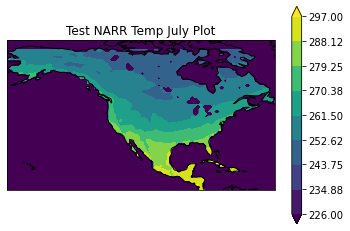

In [19]:
var_to_plot = final_input[0:2613,-2]
xi, yi, zi_flux = data2grid(lat_NA_var,lon_NA_var,var_to_plot) # regrid for plotting

# projection axis    
ax = plt.axes(projection=ccrs.PlateCarree())

# plot contour of variable using gridded  lat, lon, and variable
lower_lim = np.round(np.mean(var_to_plot)-3*np.std(var_to_plot))
upper_lim = np.round(np.mean(var_to_plot)+3*np.std(var_to_plot))

levels = np.linspace(lower_lim, upper_lim, 9)

# plot contour of variable using gridded  lat, lon, and variable
plt.contourf(xi, yi, zi_flux, 60,levels=levels,
                 transform=ccrs.PlateCarree(),extend='both')
#add coasts
ax.coastlines()

# title
plt.title("Test NARR Temp July Plot")
plt.colorbar()

plt.show()

In [20]:
# Load in target data (GIM fluxes)
# filename for inverse carbon fluxes (units are umol/m2/s)
filename_flux = data_dir + "flux_training/geoinv-sif-monthly-2007-to-2015.nc"
nc_inv = Dataset(filename_flux, 'r')  # open inversion file using netcdf reader
flux_var = np.array(nc_inv.variables['monthly_flux']) # create numpy array note shape of flux is [ time dimension x space dimension]
num_rows, num_cols = flux_var.shape # number of rows and columns
flux_var=flux_var.reshape((num_rows*num_cols, 1),) # reshape into one vector by stacking each column (month)
print(flux_var.shape)
flux_var_GIM = flux_var


(282204, 1)


array([-1.40817765])

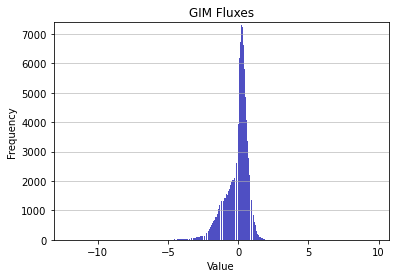

In [21]:
n, bins, patches = plt.hist(x=flux_var_GIM, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('GIM Fluxes')
#plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
scipy.stats.skew(flux_var_GIM)

In [22]:
# Indentify correct dates (rows) for training
print(time_convert[28*12])
print(time_convert[(28+9)*12-1])
features_2007_2015 = final_trim[28*12*2613:2613*(28+9)*12,:]
print(features_2007_2015.shape)

2007-01-01 00:00:00
2015-12-01 00:00:00
(282204, 9)


In [23]:
# validation binaries

# yearly - get all combinations of two years
length_of_feature_year = 2613*12
years_total = 9 
length_of_feature = length_of_feature_year*years_total
year_pair_index = np.array(list(itertools.combinations(range(years_total), 2)))
binary_yearly=np.empty((length_of_feature,year_pair_index.shape[0]))
# generate binaries with year_pair_index values set to zero
for rows in range(year_pair_index.shape[0]):
    ones_mat_temp = np.ones((length_of_feature_year,years_total))
    ones_mat_temp[:,year_pair_index[rows]]=0;
    a=np.ravel(ones_mat_temp,order='F')
    binary_yearly[:,rows] = a
binary_yearly = np.array(binary_yearly)

In [24]:
# load land cover data 
aux_dir = '/Users/yshiga/Documents/Research/Carbon_Machine/Aux_data/'
filename_land = aux_dir + "land_cover_NA_pct_2613.nc"
nc_land = Dataset(filename_land, 'r')  # open data file using netcdf reader
land_var= np.array(nc_land.variables["land_cover_pct"]) # create numpy array note shape of narr vars is [space dimension x time dimension]
land_var_full=np.tile(land_var,(1,9*12))
land_var_full = np.transpose(land_var_full)

In [25]:
# load stand age data 
aux_dir = '/Users/yshiga/Documents/Research/Carbon_Machine/Aux_data/'
filename_stand = aux_dir + "stand_age_GFAD_2613.nc"
nc_stand = Dataset(filename_stand, 'r')  # open data file using netcdf reader
stand_age_var= np.array(nc_stand.variables["stand_age"]) # create numpy array note shape of narr vars is [space dimension x time dimension]
stand_age_var_full=np.tile(stand_age_var,(1,9*12))
stand_age_var_full = np.transpose(stand_age_var_full)

In [26]:
# load sif data 
filename_sif = data_dir + "predictors/processed/sif-2007-to-2016-NA-monthly.nc"
nc_sif = Dataset(filename_sif, 'r')  # open data file using netcdf reader
sif_varR = np.array(nc_sif.variables["RSIF::SIF"]) # create numpy array note shape of narr vars is [space dimension x time dimension]
num_rows, num_cols = sif_varR.shape # number of rows and columns
sif_varR=sif_varR.reshape((num_rows*num_cols, 1),order='F') # reshape into one vector by stacking each column (month)
sif_varR=sif_varR[0:2613*9*12]
#ind_sifR=np.isnan(sif_varR)
#sif_varR[ind_sifR] = 0

In [27]:
# create feature set for NN
features_2007_2015=np.hstack([land_var_full,features_2007_2015])
print(features_2007_2015.shape)

(282204, 27)


In [147]:
# train nn model using validation year set and stopping at n epochs 
n = 150
target_train,feature_train,target_validation,feature_validation = create_hold_outs(binary_yearly[:,32],flux_var_GIM,features_2007_2015)
feature_train, feature_validation = transform_features(feature_train,feature_validation)
model = model_maker('nn',feature_train)
history = nn_model_train(model,target_train,feature_train,target_validation,feature_validation,n)

Epoch 00008: early stopping


In [148]:
model.save(model_dir + "nn_32_es2")


In [37]:

model = keras.models.load_model(model_dir + "nn_32_es2")
model

In [40]:
target_train,feature_train,target_validation,feature_validation = create_hold_outs(binary_yearly[:,32],flux_var_GIM,features_2007_2015)
feature_train, feature_validation = transform_features(feature_train,feature_validation)
background = feature_train[np.random.choice(feature_train.shape[0],100, replace=False)]
shap.initjs()

explainer = shap.DeepExplainer(model,background)
#shap_values = explainer(feature_train)

ValueError: Layer sequential_1 was called with an input that isn't a symbolic tensor. Received type: <class 'numpy.ndarray'>. Full input: [array([[-0.59162065, -0.35992584, -0.15926296, ..., -0.30798749,
         1.01635539, -0.57498134],
       [-0.59162065, -0.61998965, -0.15926296, ..., -1.16812616,
        -1.83270228,  0.38813404],
       [ 3.16430476,  0.96342744, -0.15926296, ...,  0.50862708,
         0.54364756, -0.57414448],
       ...,
       [-0.33553482,  2.82771345, -0.15926296, ..., -1.05745741,
        -1.48209009,  0.85042651],
       [-0.59162065, -0.02555808, -0.15926296, ..., -0.65865482,
        -0.53519541,  1.08249023],
       [-0.59162065, -0.61998965, -0.15926296, ..., -1.03031125,
        -1.35230594,  1.73033174]])]. All inputs to the layer should be tensors.

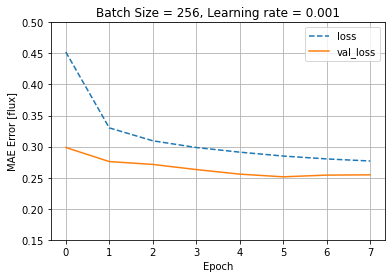

In [149]:
# plot error vs epoch history
plot_loss_2(history,model)

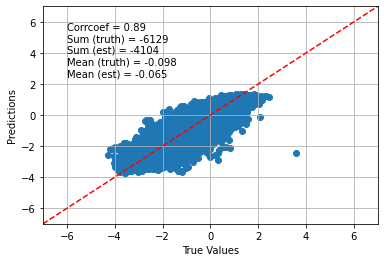

In [150]:
# plot scatter of test with basic stats
model_scatter_correlation(model,feature_validation,target_validation)

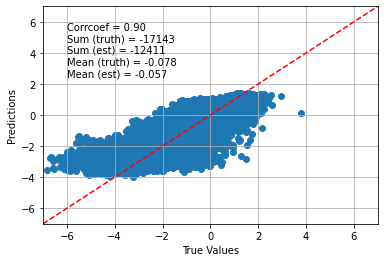

In [151]:
# plot scatter of test with basic stats
model_scatter_correlation(model,feature_train,target_train)

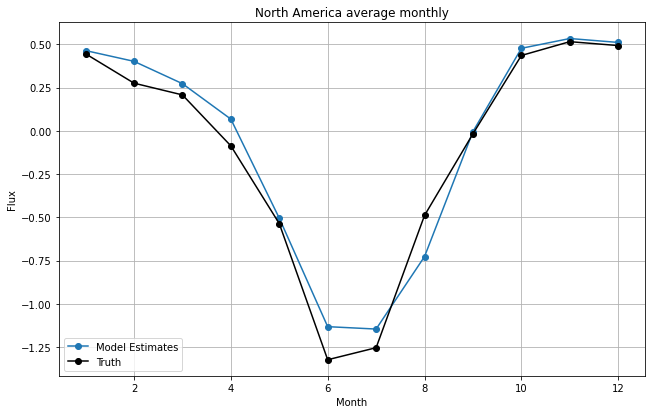

In [152]:
# plots for seasonal comparisons
model_seasonal_plots(model,feature_validation,target_validation)

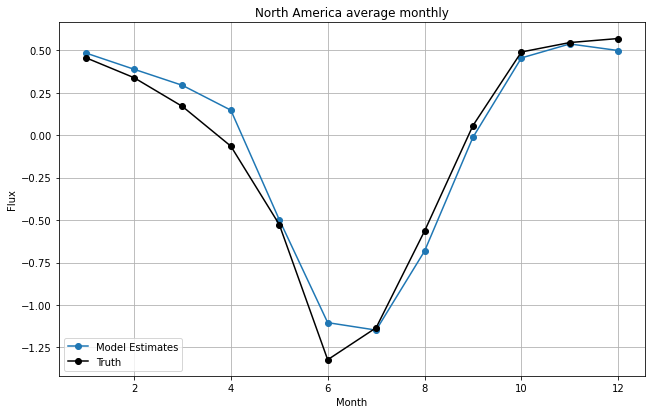

In [153]:
# plots for seasonal comparisons
model_seasonal_plots(model,feature_train,target_train)

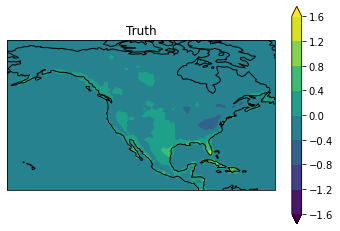

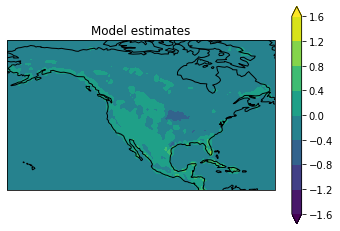

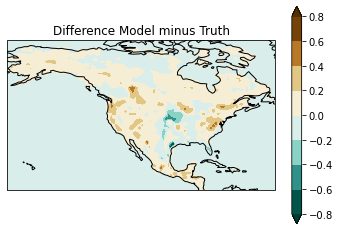

In [154]:
# plot scatter of test with basic stats
model_spatial_plots(model,feature_validation,target_validation,lat_NA_var,lon_NA_var)

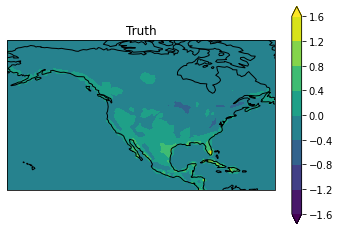

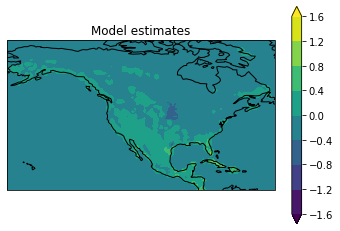

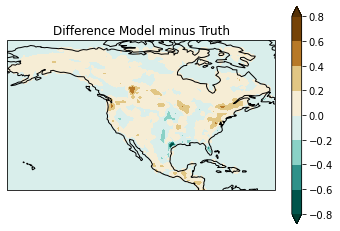

In [155]:
# plot scatter of test with basic stats
model_spatial_plots(model,feature_train,target_train,lat_NA_var,lon_NA_var)

In [156]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               2800      
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)              

In [157]:
# Use model to estimate long term NEE from NARR data
scaler_x_train = preprocessing.StandardScaler()
#scaler_x_train = preprocessing.MinMaxScaler(feature_range=(0, 1))

# Transform inputs (fit)

land_var_long = np.tile(land_var,(1,42*12))
land_var_long = np.transpose(land_var_long)
features_1979_2020 = final_trim[0:2613*12*42,:]

features_1979_2020 = np.hstack([land_var_long,features_1979_2020])

scaler_x_train.fit(features_1979_2020)

# Transform inputs (fit)
X_final_trim = scaler_x_train.fit_transform(features_1979_2020) 

In [158]:
# Predict output using trained model
y_est = model.predict(X_final_trim, batch_size=len(X_final_trim)) # model estimates for long term data 

In [159]:
# Predict output of second to last layer using trained model
layer_name = 'batch_normalization_6'
intermediate_layer_model = keras.models.Model(inputs = model.inputs, outputs = model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X_final_trim, batch_size=len(X_final_trim))
intermediate_output.shape

(1316952, 5)

In [160]:
# compare to long term inversions
inv_dir = '/Users/yshiga/Documents/Research/RECCAP2/DATA/NA_trim_2613/'

filename_flux = inv_dir + "Regional_budget_Jena_sEXTocNEET_v2020_daily_trim_2613.nc"
nc_inv = Dataset(filename_flux, 'r')  # open inversion file using netcdf reader
flux_var = np.array(nc_inv.variables['monthly_flux']) # create numpy array note shape of flux is [ time dimension x space dimension]
num_rows, num_cols = flux_var.shape # number of rows and columns
flux_var=flux_var.reshape((num_rows*num_cols, 1),) # reshape into one vector by stacking each column (month)
area_var = np.array(nc_inv.variables['area']) # create numpy array note shape of flux is [ time dimension x space dimension]
# convert kgC/m2/year to PgC/year
area_2 = np.tile(area_var,int(flux_var.shape[0]/2613))
flux_var_X_area=flux_var[:,0]*area_2 # multiply by area kgC/m2/month to kgC/month
flux_var_Jena = flux_var_X_area*1000 # multiply by 1000 to get grams C per month


filename_flux = inv_dir + "Regional_budget_CAMS_v20r1_trim_2613.nc"
nc_inv = Dataset(filename_flux, 'r')  # open inversion file using netcdf reader
flux_var = np.array(nc_inv.variables['monthly_flux']) # create numpy array note shape of flux is [ time dimension x space dimension]
num_rows, num_cols = flux_var.shape # number of rows and columns
flux_var=flux_var.reshape((num_rows*num_cols, 1),) # reshape into one vector by stacking each column (month)
area_var = np.array(nc_inv.variables['area']) # create numpy array note shape of flux is [ time dimension x space dimension]
# convert kgC/m2/year to PgC/year
area_2 = np.tile(area_var,int(flux_var.shape[0]/2613))
print(area_2.shape)
flux_var_X_area=flux_var[:,0]*area_2 # multiply by area kgC/m2/month to kgC/month
flux_var_CAMS = flux_var_X_area*1000 # multiply by 1000 to get grams C per month



filename_flux = inv_dir + "Regional_budget_CTL_trim_2613.nc"
nc_inv = Dataset(filename_flux, 'r')  # open inversion file using netcdf reader
flux_var = np.array(nc_inv.variables['monthly_flux']) # create numpy array note shape of flux is [ time dimension x space dimension]
print(flux_var.shape)
num_rows, num_cols = flux_var.shape # number of rows and columns
flux_var=flux_var.reshape((num_rows*num_cols, 1)) # reshape into one vector by stacking each column (month)
area_var = np.array(nc_inv.variables['area']) # create numpy array note shape of flux is [ time dimension x space dimension]
# convert kgC/m2/year to PgC/year
area_2 = np.tile(area_var,int(flux_var.shape[0]/2613))
flux_var_X_area=flux_var[:,0]*area_2 # multiply by area kgC/m2/month to kgC/month
flux_var_CTL = flux_var_X_area*1000 # multiply by 1000 to get grams C per month


(627120,)
(108, 2613)


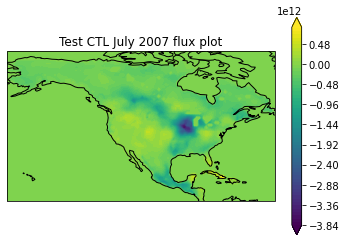

In [161]:
var_to_plot = flux_var_CTL[2613*6:2613*7]
xi, yi, zi_flux = data2grid(lat_NA_var,lon_NA_var,var_to_plot) # regrid for plotting

# projection axis    
ax = plt.axes(projection=ccrs.PlateCarree())

# plot contour of variable using gridded  lat, lon, and variable
plt.contourf(xi, yi, zi_flux, 60,
                 transform=ccrs.PlateCarree(),extend='both')
#add coasts
ax.coastlines()

# title
plt.title("Test CTL July 2007 flux plot")
plt.colorbar()

plt.show()

In [162]:
# convert umolC/m2/s to PgC/year
y_est_x_area = y_est[:,0]*np.tile(area_var,int(y_est.shape[0]/2613)) # multiply by area -> umolC/s
y_est_x_area_x_mm = y_est_x_area*(12.0107/1000000) # multiply by molar mass of carbon and divide by 10^6 -> gC/s
y_NN = y_est_x_area_x_mm*(30*24*60*60) # grams per month

# convert umolC/m2/s to PgC/year
y_est_x_area = flux_var_GIM[:,0]*np.tile(area_var,int(flux_var_GIM.shape[0]/2613)) # multiply by area -> umolC/s
y_est_x_area_x_mm = y_est_x_area*(12.0107/1000000) # multiply by molar mass of carbon and divide by 10^6 -> gC/s
y_GIM = y_est_x_area_x_mm*(30*24*60*60) # grams per month

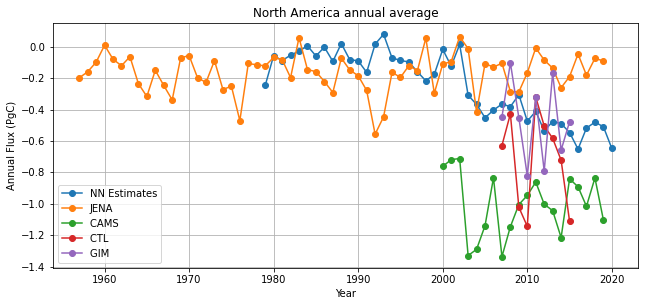

In [163]:
# plot long term timeseries of fluxes

y_means_jena=np.sum(np.reshape(flux_var_Jena,(2613*12,-1),order='F'),0)
y_means_cams=np.sum(np.reshape(flux_var_CAMS,(2613*12,-1),order='F'),0)
y_means_ctl=np.sum(np.reshape(flux_var_CTL,(2613*12,-1),order='F'),0)
y_means_est=np.sum(np.reshape(y_NN,(2613*12,-1),order='F'),0)
y_means_gim=np.sum(np.reshape(y_GIM,(2613*12,-1),order='F'),0)

x_time_ctl = range(2007,2016)
x_time_cams = range(2000,2020)
x_time_jena = range(1957,2020)
x_time = range(1979,2021)
# plt.plot(x_time,(y_means_est-np.mean(y_means_est))/np.std(y_means_est),'-o',label="Model Estimates")
# plt.plot(x_time_jena,(y_means_jena-np.mean(y_means_jena))/np.std(y_means_jena),'-o',label="Jena ")
plt.plot(x_time,y_means_est/np.power(10, 15),'-o',label="NN Estimates")
plt.plot(x_time_jena,y_means_jena/np.power(10, 15),'-o',label="JENA ")
plt.plot(x_time_cams,y_means_cams/np.power(10, 15),'-o',label="CAMS ")
plt.plot(x_time_ctl,y_means_ctl/np.power(10, 15),'-o',label="CTL ")
plt.plot(x_time_ctl,y_means_gim/np.power(10, 15),'-o',label="GIM ")

plt.grid(True)
plt.legend(loc="lower left")
plt.xlabel('Year')
plt.ylabel('Annual Flux (PgC)')
plt.title('North America annual average')
fig = plt.gcf()
fig.set_size_inches(10.5, 4.5)
plt.show()

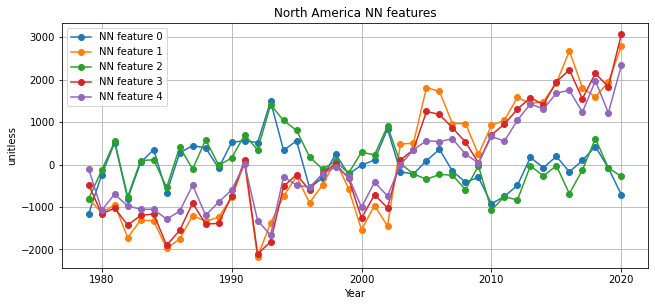

In [164]:
# plot long term timeseries of features
for rows in range(intermediate_output.shape[1]):
    y_means_temp=np.sum(np.reshape((intermediate_output[:,rows]-np.mean(intermediate_output[:,rows]))/np.std(intermediate_output[:,rows]),(2613*12,-1),order='F'),0)

    x_time = range(1979,2021)
# plt.plot(x_time,(y_means_est-np.mean(y_means_est))/np.std(y_means_est),'-o',label="Model Estimates")
# plt.plot(x_time_jena,(y_means_jena-np.mean(y_means_jena))/np.std(y_means_jena),'-o',label="Jena ")
    plt.plot(x_time,y_means_temp,'-o',label='NN feature ' + str(rows)  )

plt.grid(True)
plt.legend(loc="upper left")
plt.xlabel('Year')
plt.ylabel('unitless')
plt.title('North America NN features')
fig = plt.gcf()
fig.set_size_inches(10.5, 4.5)
plt.show()

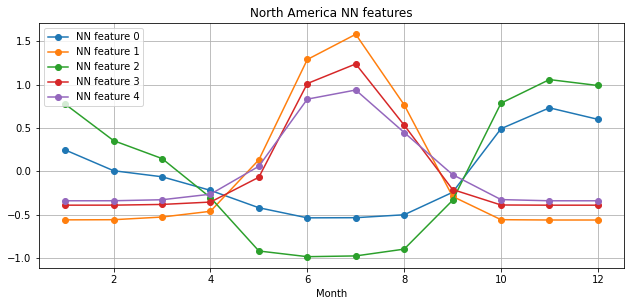

In [165]:
# plot long term seasonal mean of features
fig=plt.figure()
for rows in range(intermediate_output.shape[1]):
    temp = (intermediate_output[:,rows]-np.mean(intermediate_output[:,rows]))/np.std(intermediate_output[:,rows])
    b = np.reshape(np.ravel(temp, order='F'), (2613,12,1,-1),order='F')
    X_tru_mon = np.mean(b,axis=0)
    X_tru_mon = np.mean(X_tru_mon,axis=1)
    # month variable
    mon_array = np.arange(1, 13, dtype=float)
    # plot monthly averages averaged over all North America
    plt.plot(mon_array,X_tru_mon[:,0],'-o',label='NN feature ' + str(rows))
    
plt.grid(True)
plt.legend(loc="upper left")
plt.xlabel('Month')
plt.title('North America NN features')
fig = plt.gcf()
fig.set_size_inches(10.5, 4.5)
plt.show()

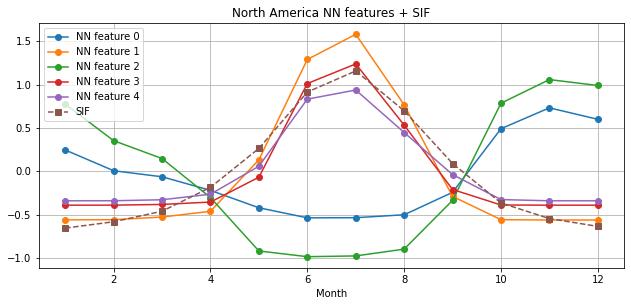

In [166]:
# plot long term seasonal mean of features
fig=plt.figure()
for rows in range(intermediate_output.shape[1]):
    temp = (intermediate_output[:,rows]-np.mean(intermediate_output[:,rows]))/np.std(intermediate_output[:,rows])
    b = np.reshape(np.ravel(temp, order='F'), (2613,12,1,-1),order='F')
    X_tru_mon = np.mean(b,axis=0)
    X_tru_mon = np.mean(X_tru_mon,axis=1)
    # month variable
    mon_array = np.arange(1, 13, dtype=float)
    # plot monthly averages averaged over all North America
    plt.plot(mon_array,X_tru_mon[:,0],'-o',label='NN feature ' + str(rows))

temp = (sif_varR[:,0]-np.nanmean(sif_varR[:,0]))/np.nanstd(sif_varR[:,0])
b = np.reshape(np.ravel(temp, order='F'), (2613,12,1,-1),order='F')
X_tru_mon = np.nanmean(b,axis=0)
X_tru_mon = np.nanmean(X_tru_mon,axis=1)
# month variable
mon_array = np.arange(1, 13, dtype=float)
# plot monthly averages averaged over all North America
plt.plot(mon_array,X_tru_mon[:,0],'--s',label='SIF')

plt.grid(True)
plt.legend(loc="upper left")
plt.xlabel('Month')
plt.title('North America NN features + SIF')
fig = plt.gcf()
fig.set_size_inches(10.5, 4.5)
plt.show()

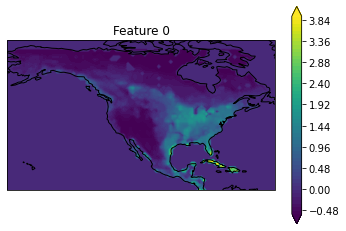

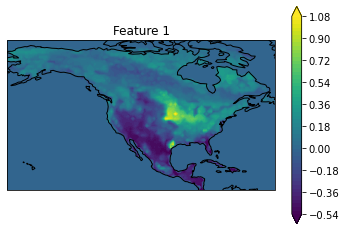

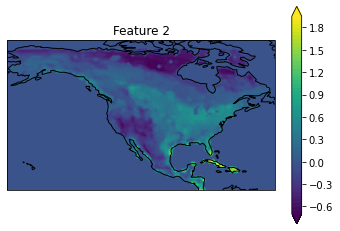

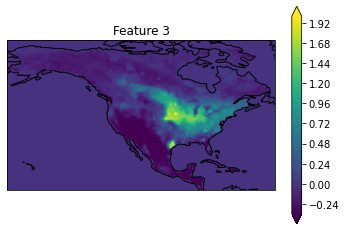

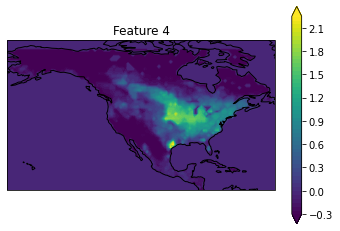

In [167]:
# plot spatial pattern of features
fig=plt.figure()

for i in range(intermediate_output.shape[1]):
    temp_1= (intermediate_output[:,i]-np.mean(intermediate_output[:,i]))/np.std(intermediate_output[:,i])
    y_means_temp_space = np.mean(np.reshape(temp_1,(2613,-1),order='F'),1)
    var_to_plot = y_means_temp_space
    xi, yi, zi_flux = data2grid(lat_NA_var,lon_NA_var,var_to_plot) # regrid for plotting
    ax=plt.subplot(2,5,1+i)

    # projection axis    
    ax = plt.axes(projection=ccrs.PlateCarree())
    plt.contourf(xi, yi, zi_flux, 60,
                     transform=ccrs.PlateCarree(),extend='both')
    #add coasts
    ax.coastlines()
    # title
    plt.title('Feature ' + str(i))
    # colorbar
    plt.colorbar()
    plt.show()
    
    

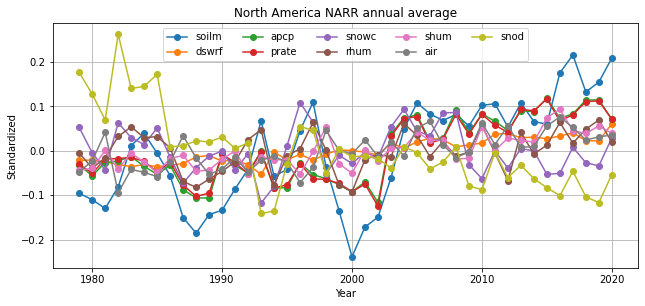

In [168]:
# plot long term timeseries of NARR
for i in range(9):
    temp_1= (features_1979_2020[:,i+18]-np.mean(features_1979_2020[:,i+18]))/np.std(features_1979_2020[:,i+18])

    y_means_est=np.mean(np.reshape(temp_1,(2613*12,-1),order='F'),0)



    x_time = range(1979,2021)
# plt.plot(x_time,(y_means_est-np.mean(y_means_est))/np.std(y_means_est),'-o',label="Model Estimates")
# plt.plot(x_time_jena,(y_means_jena-np.mean(y_means_jena))/np.std(y_means_jena),'-o',label="Jena ")
    plt.plot(x_time,y_means_est,'-o',label = all_names_input[i])


plt.grid(True)
plt.legend(loc="upper center",ncol=5)
plt.xlabel('Year')
plt.ylabel('Standardized')
plt.title('North America NARR annual average')
fig = plt.gcf()
fig.set_size_inches(10.5, 4.5)
plt.show()